<a href="https://colab.research.google.com/github/zouidine/ASA_LLMs/blob/master/mixtral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/zouidine/ASA_LLMs.git

Cloning into 'ASA_LLMs'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 81 (delta 15), reused 33 (delta 9), pack-reused 37
Receiving objects: 100% (81/81), 13.32 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [2]:
pip install langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.8/321.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.3 MB/s eta 0:00:00


In [3]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from langchain_groq import ChatGroq
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [4]:
data = open("/content/ASA_LLMs/data/test_samples.tsv",
            encoding='utf-16').read().strip().split('\n')
texts = [x.split('\t')[0] for x in data]
labels = [int(x.split('\t')[1]) for x in data]

data = open("/content/ASA_LLMs/data/train_samples.tsv",
            encoding='utf-16').read().strip().split('\n')
train_texts = [x.split('\t')[0] for x in data]
train_labels = [int(x.split('\t')[1]) for x in data]

#Zero-shot

In [9]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,
                    api_key=GROQ_API_KEY, max_tokens=1)

system_message = """Classify the input text as 'positive' or 'negative'.
The text will be delimited by triple backticks ``` in the input.
Answer only with 'positive' or 'negative'.
Do not explain your answer!"""
user_message_template ="Text: ```{text}```"

generated_labels = []
for i in tqdm(range(len(texts))):
    zero_shot_prompt = [{"role":"system", "content":system_message},
     {"role":"user", "content":user_message_template.format(text= texts[i])}]
    response = groq_llm.invoke(zero_shot_prompt)
    label = 1 if response.content.lower() == 'positive' else 0
    generated_labels.append(label)

100%|██████████| 500/500 [20:00<00:00,  2.40s/it]


In [10]:
acc = accuracy_score(labels, generated_labels)
pre = precision_score(labels, generated_labels)
rec = recall_score(labels, generated_labels)
f1s = f1_score(labels, generated_labels)

print(f'\nAcc: {acc*100:.2f}%\nPre: {pre*100:.2f}%\nRec: {rec*100:.2f}%\nF1s: {f1s*100:.2f}%')


Acc: 69.80%
Pre: 83.67%
Rec: 49.20%
F1s: 61.96%


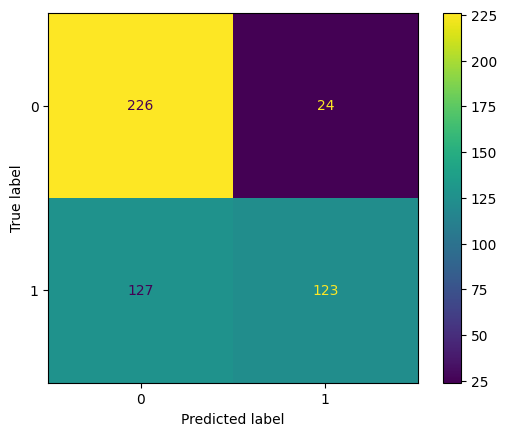

In [11]:
cm = confusion_matrix(labels, generated_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#Few-shot

In [5]:
def create_examples(positive_reviews, negative_reviews, n=4):
    examples = []
    positive_examples = random.sample(positive_reviews, n)
    negative_examples = random.sample(negative_reviews, n)

    for i in range(n):
        examples.append({'text': positive_examples[i], 'sentiment': 'positive'})
        examples.append({'text': negative_examples[i], 'sentiment': 'negative'})
    return examples

def create_prompt(system_message, examples, user_message_template):
    few_shot_prompt = [{'role':'system', 'content':system_message}]
    for example in examples:
        example_review = example['text']
        example_sentiment = example['sentiment']
        few_shot_prompt.append(
            {'role':'user',
             'content':user_message_template.format(text=example_review)}
        )
        few_shot_prompt.append(
            {'role':'assistant', 'content':f"{example_sentiment}"}
        )
    return few_shot_prompt

##1-shot

In [6]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,
                    api_key=GROQ_API_KEY, max_tokens=1)

positive_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 1]
negative_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 0]
examples = create_examples(positive_reviews, negative_reviews, 1)

system_message = """Classify the input text as 'positive' or 'negative'.
The text will be delimited by triple backticks ``` in the input.
Answer only with 'positive' or 'negative'.
Do not explain your answer!"""
user_message_template ="Text: ```{text}```"

generated_labels = []
for i in tqdm(range(len(texts))):
    prompt = create_prompt(system_message, examples, user_message_template)
    prompt.append({"role":"user",
                   "content":user_message_template.format(text=texts[i])})
    response = groq_llm.invoke(prompt)
    label = 1 if response.content.lower() == 'positive' else 0
    generated_labels.append(label)

100%|██████████| 500/500 [29:55<00:00,  3.59s/it]


In [7]:
acc = accuracy_score(labels, generated_labels)
pre = precision_score(labels, generated_labels)
rec = recall_score(labels, generated_labels)
f1s = f1_score(labels, generated_labels)

print(f'\nAcc: {acc*100:.2f}%\nPre: {pre*100:.2f}%\nRec: {rec*100:.2f}%\nF1s: {f1s*100:.2f}%')


Acc: 81.20%
Pre: 78.89%
Rec: 85.20%
F1s: 81.92%


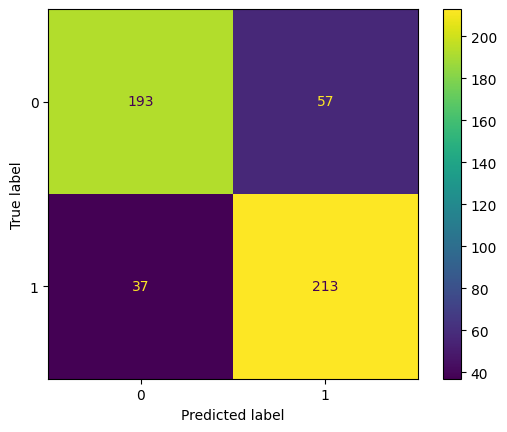

In [8]:
cm = confusion_matrix(labels, generated_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##2-shot

In [9]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,
                    api_key=GROQ_API_KEY, max_tokens=1)

positive_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 1]
negative_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 0]
examples = create_examples(positive_reviews, negative_reviews, 2)

system_message = """Classify the input text as 'positive' or 'negative'.
The text will be delimited by triple backticks ``` in the input.
Answer only with 'positive' or 'negative'.
Do not explain your answer!"""
user_message_template ="Text: ```{text}```"

generated_labels = []
for i in tqdm(range(len(texts))):
    prompt = create_prompt(system_message, examples, user_message_template)
    prompt.append({"role":"user",
                   "content":user_message_template.format(text=texts[i])})
    response = groq_llm.invoke(prompt)
    label = 1 if response.content.lower() == 'positive' else 0
    generated_labels.append(label)

100%|██████████| 500/500 [45:53<00:00,  5.51s/it]


In [10]:
acc = accuracy_score(labels, generated_labels)
pre = precision_score(labels, generated_labels)
rec = recall_score(labels, generated_labels)
f1s = f1_score(labels, generated_labels)

print(f'\nAcc: {acc*100:.2f}%\nPre: {pre*100:.2f}%\nRec: {rec*100:.2f}%\nF1s: {f1s*100:.2f}%')


Acc: 82.40%
Pre: 79.78%
Rec: 86.80%
F1s: 83.14%


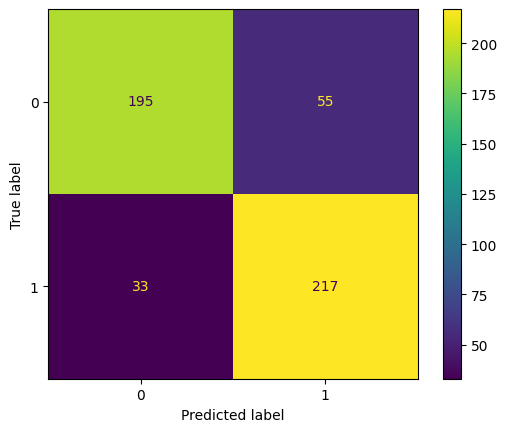

In [11]:
cm = confusion_matrix(labels, generated_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

##3-shot

In [12]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"
groq_llm = ChatGroq(model_name="mixtral-8x7b-32768", temperature=0,
                    api_key=GROQ_API_KEY, max_tokens=1)

positive_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 1]
negative_reviews = [train_texts[i] for i in range(len(train_texts)) if train_labels[i] == 0]
examples = create_examples(positive_reviews, negative_reviews, 3)

system_message = """Classify the input text as 'positive' or 'negative'.
The text will be delimited by triple backticks ``` in the input.
Answer only with 'positive' or 'negative'.
Do not explain your answer!"""
user_message_template ="Text: ```{text}```"

generated_labels = []
for i in tqdm(range(len(texts))):
    prompt = create_prompt(system_message, examples, user_message_template)
    prompt.append({"role":"user",
                   "content":user_message_template.format(text=texts[i])})
    response = groq_llm.invoke(prompt)
    label = 1 if response.content.lower() == 'positive' else 0
    generated_labels.append(label)

100%|██████████| 500/500 [1:21:43<00:00,  9.81s/it]


In [13]:
acc = accuracy_score(labels, generated_labels)
pre = precision_score(labels, generated_labels)
rec = recall_score(labels, generated_labels)
f1s = f1_score(labels, generated_labels)

print(f'\nAcc: {acc*100:.2f}%\nPre: {pre*100:.2f}%\nRec: {rec*100:.2f}%\nF1s: {f1s*100:.2f}%')


Acc: 84.60%
Pre: 83.66%
Rec: 86.00%
F1s: 84.81%


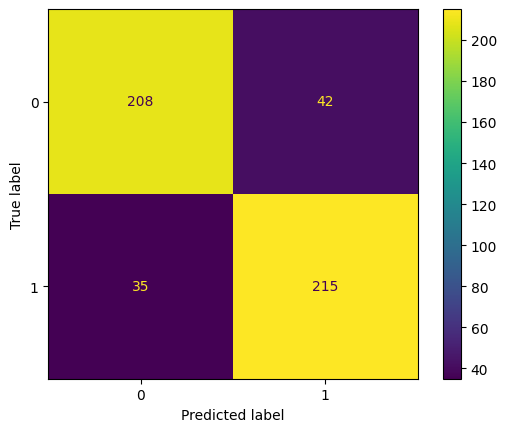

In [14]:
cm = confusion_matrix(labels, generated_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()